In [74]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join

plt.style.use('default') # haciendo los graficos un poco mas bonitos xD
plt.rcParams['figure.figsize'] = (5, 5)

In [75]:
#-----------------------------------------------------
def filter(array):
    priceUSD, usdM2, surfaceTotal = array
    if np.isnan(surfaceTotal) or surfaceTotal == 0:
        return np.nan
    if not np.isnan(priceUSD) and not np.isnan(usdM2):
        price = usdM2 * surfaceTotal
        dif = abs(price - priceUSD)
        if (dif/priceUSD)*100 <= 10:
            return 1
    return 1
#-----------------------------------------------------
def fillPrice(array):
    priceUSD, usdM2, surfaceTotal = array
    if np.isnan(priceUSD) and not np.isnan(usdM2):
        return usdM2*surfaceTotal
    return priceUSD
#-----------------------------------------------------
def fillM2(array):
    priceUSD, usdM2, surfaceTotal = array
    if not np.isnan(priceUSD) and np.isnan(usdM2):
        return priceUSD/surfaceTotal
    return usdM2
#-----------------------------------------------------

In [76]:
"""miPath = "/home/sebastian/AnacondaProjects/TP/properties/"
for archive in listdir(miPath):
    if ".csv" in archive:
        df = pd.read_csv(miPath+archive, low_memory=False)
        if 'description' in df:
            df.drop('description', axis = 1, inplace = True)
        if 'image_thumbnail' in df:
            df.drop('image_thumbnail', axis = 1, inplace = True)
        if 'operation' in df:
            df.drop('operation', axis = 1, inplace = True)
        if 'price_aprox_usd' not in df:
            df.rename(columns={'price': 'price_aprox_usd'}, inplace=True)
        if 'surface_total_in_m2' not in df:
            df.rename(columns={'surface_in_m2': 'surface_total_in_m2'}, inplace=True)
        
        df.loc[:, 'price_aprox_usd'] = df.loc[:, ['price_aprox_usd']].apply(lambda x: float(x), axis=1)
        df.loc[:, 'price_usd_per_m2'] = df.loc[:, ['price_usd_per_m2']].apply(lambda x: float(x), axis=1)
        
        df['filter'] = df.loc[:, ['price_aprox_usd', 'price_usd_per_m2', 'surface_total_in_m2']].apply(filter, axis=1)
        df = df[~np.isnan(df['filter'])]
        df.loc[:, ['price_aprox_usd']] = df.loc[:, ['price_aprox_usd', 'price_usd_per_m2', 'surface_total_in_m2']].apply(fillPrice, axis=1)
        df.loc[:, ['price_usd_per_m2']] = df.loc[:, ['price_aprox_usd', 'price_usd_per_m2', 'surface_total_in_m2']].apply(fillM2, axis=1)
        df.drop('filter', axis = 1, inplace = True)
        
        if len(df.index) != 0:
            print("DSP", archive)
            df.to_csv(archive, index=True, header=True, sep=',', encoding='utf-8-sig')"""

/home/sebastian/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


('DSP', 'properati-AR-2017-05-01-properties-sell.csv')
('DSP', 'properati-AR-2014-01-01-properties-sell.csv')
('DSP', 'properati-AR-2013-08-01-properties-sell.csv')
('DSP', 'properati-AR-2015-04-01-properties-sell.csv')
('DSP', 'properati-AR-2014-02-01-properties-sell.csv')
('DSP', 'properati-AR-2013-09-01-properties-sell.csv')
('DSP', 'properati-AR-2016-09-01-properties-sell.csv')
('DSP', 'properati-AR-2017-01-01-properties-sell.csv')
('DSP', 'properati-AR-2013-10-01-properties-sell.csv')
('DSP', 'properati-AR-2015-05-01-properties-sell.csv')
('DSP', 'properati-AR-2013-12-01-properties-sell.csv')
('DSP', 'properati-AR-2014-05-01-properties-sell.csv')
('DSP', 'properati-AR-2014-11-01-properties-sell.csv')
('DSP', 'properati-AR-2014-09-01-properties-sell.csv')
('DSP', 'properati-AR-2015-02-01-properties-sell.csv')
('DSP', 'properati-AR-2016-08-01-properties-sell.csv')
('DSP', 'properati-AR-2016-01-01-properties-sell.csv')
('DSP', 'properati-AR-2016-11-01-properties-sell.csv')
('DSP', 'p

In [77]:
properties = []
for archive in listdir("."):
    if ".csv" in archive:
        df = pd.read_csv(archive, low_memory=False)
        properties.insert(-1, df)

In [78]:
CFVec = []
for cf in properties:
    CFVec.insert(-1, df.loc[df.place_with_parent_names.str.contains('Capital Federal'), :])

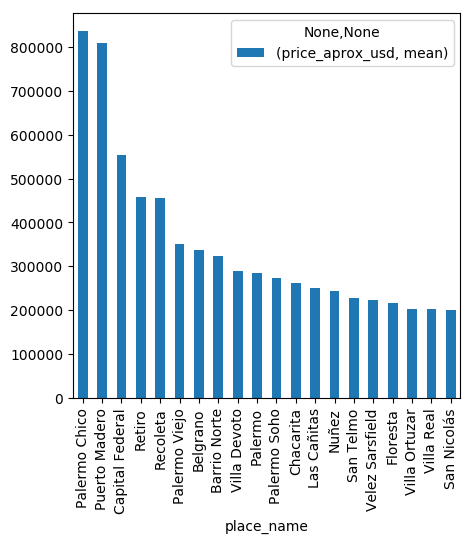

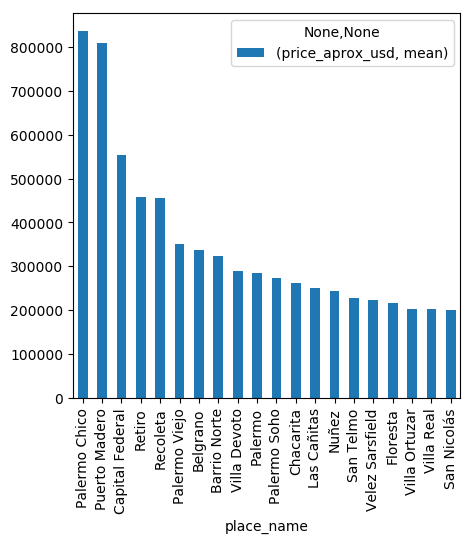

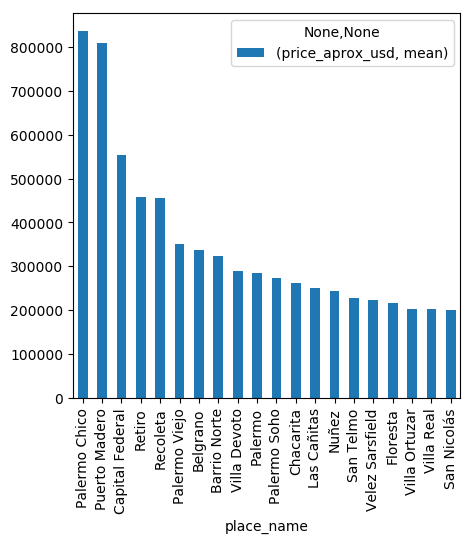

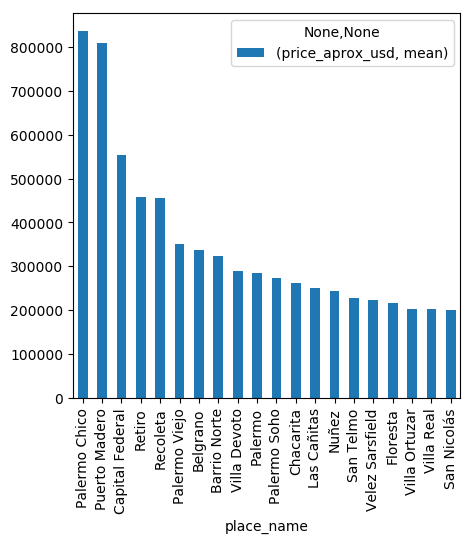

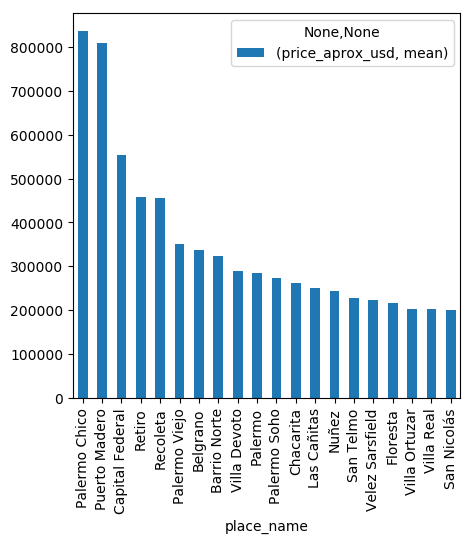

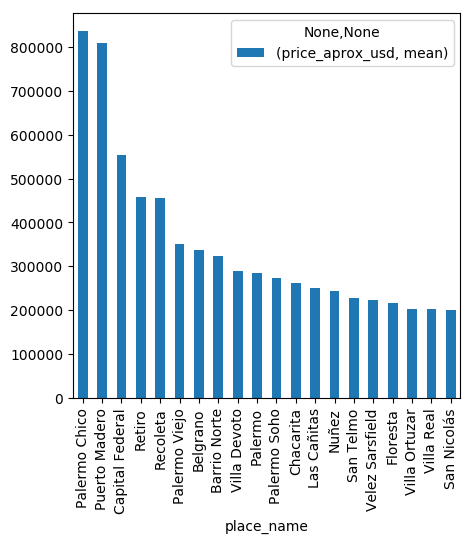

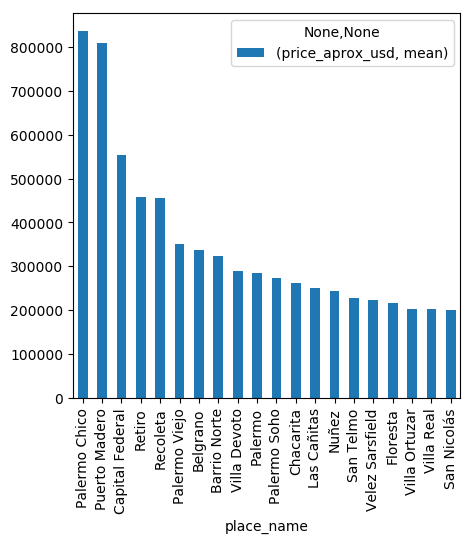

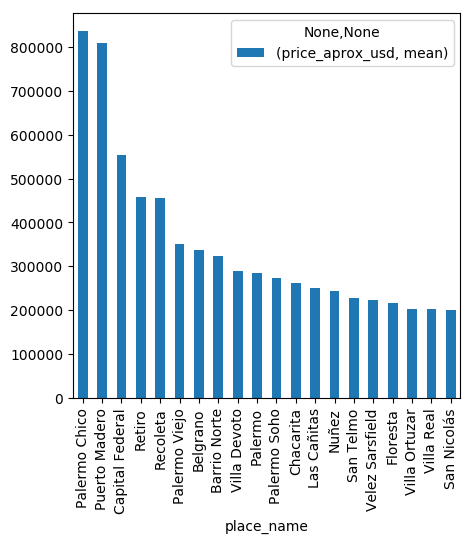

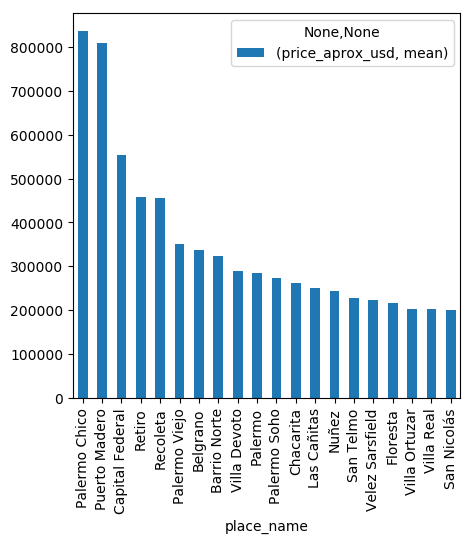

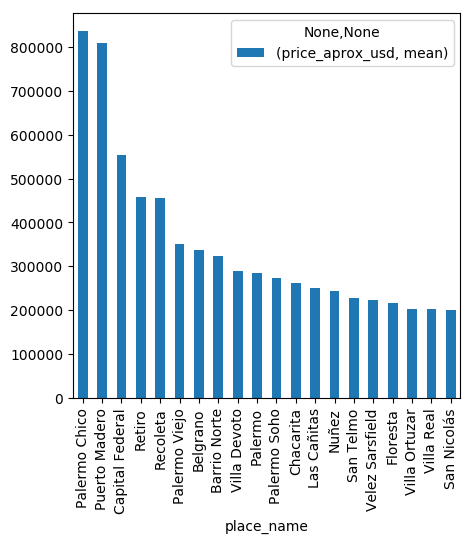

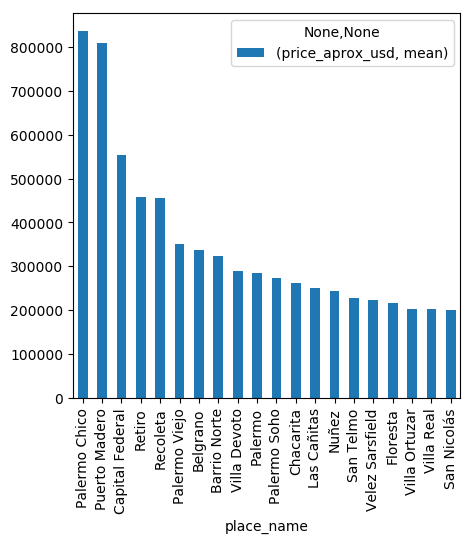

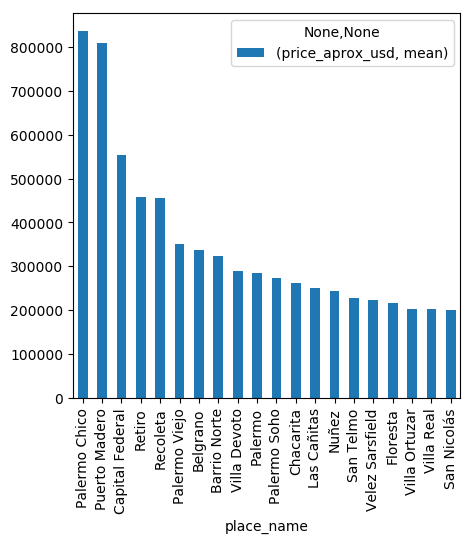

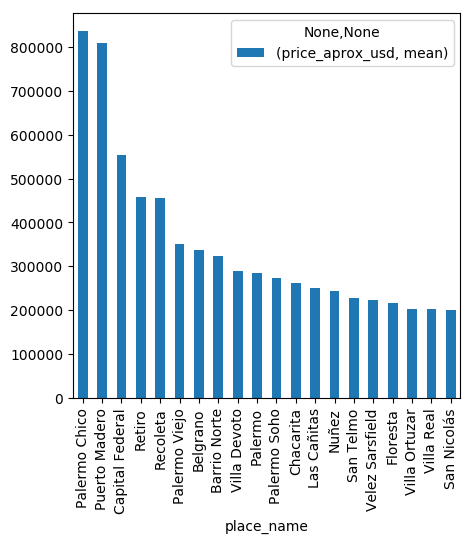

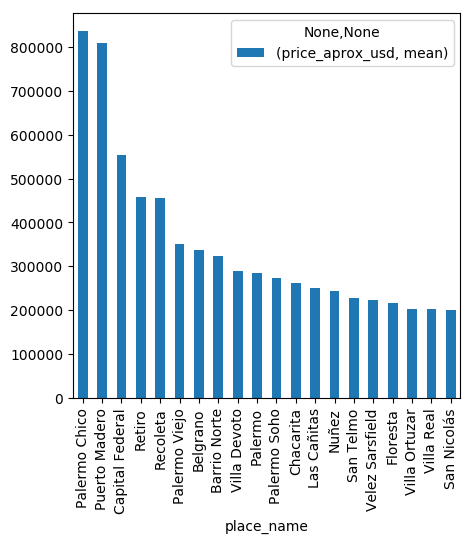

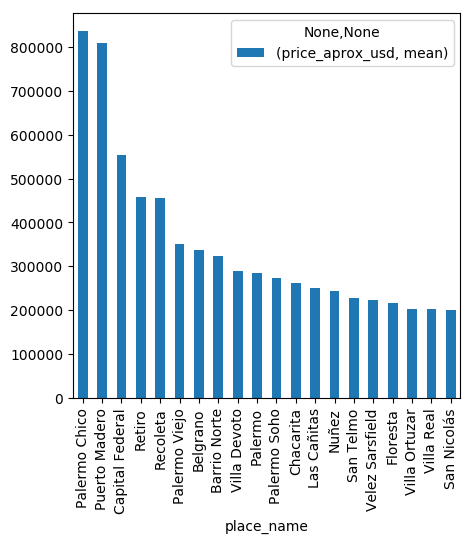

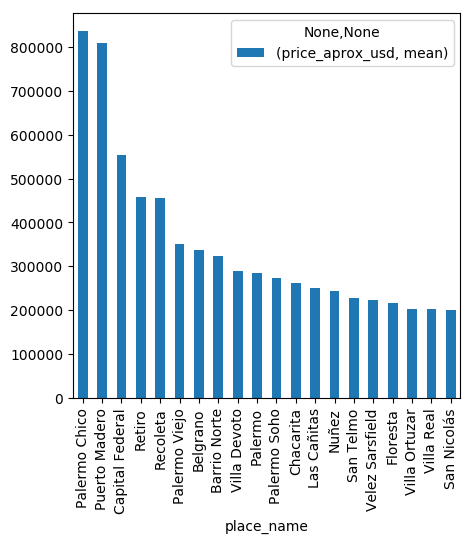

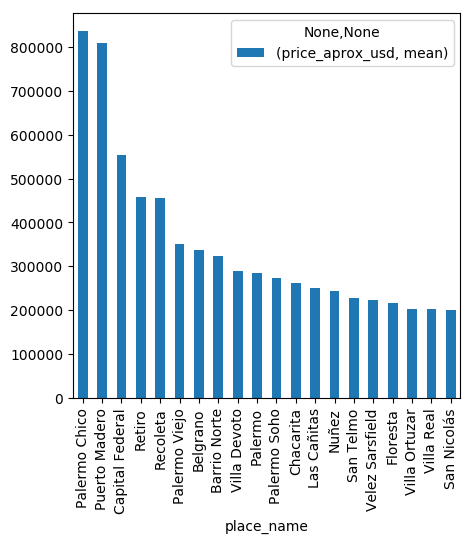

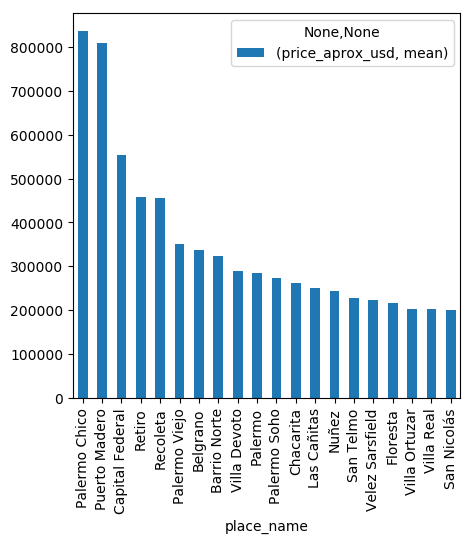

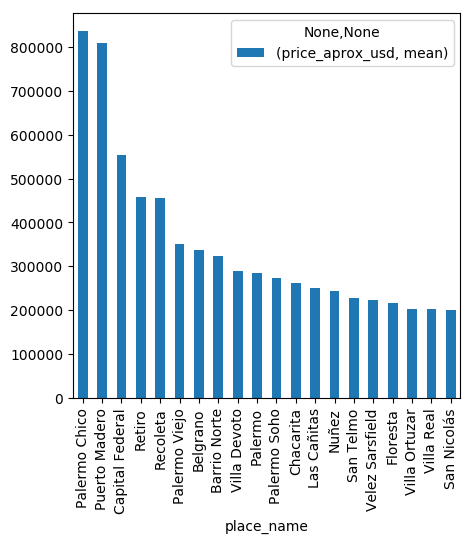

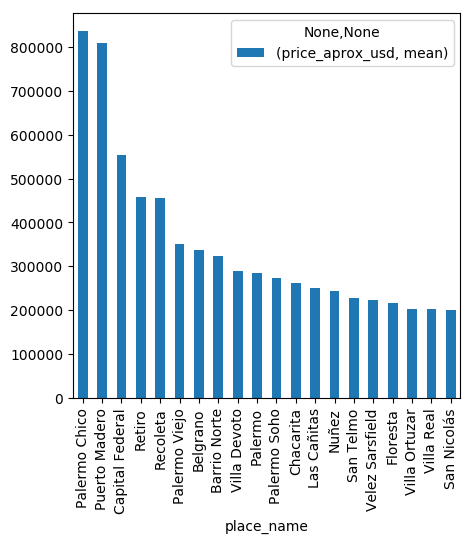

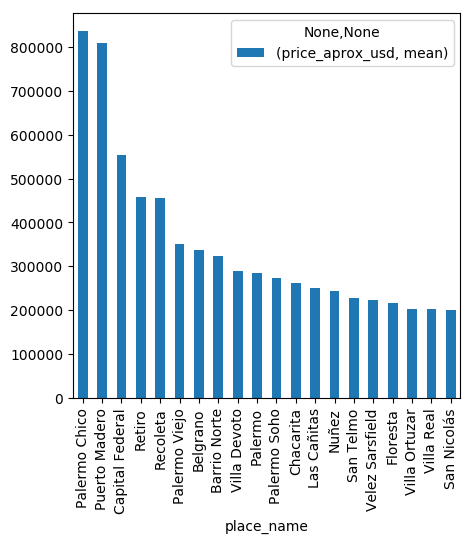

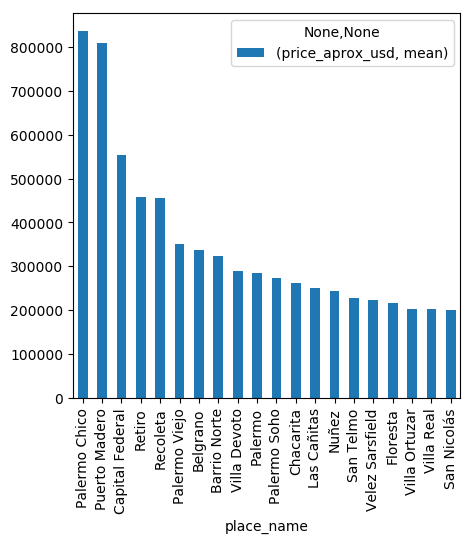

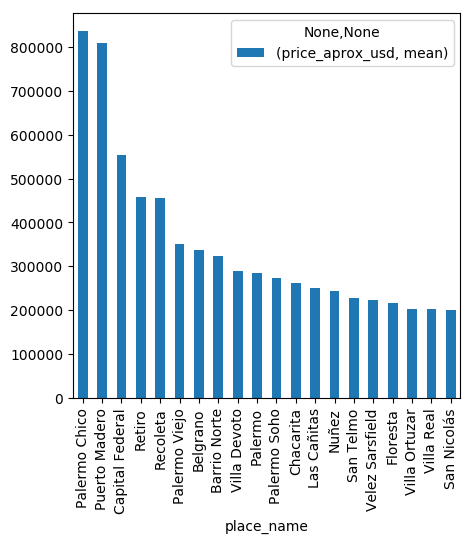

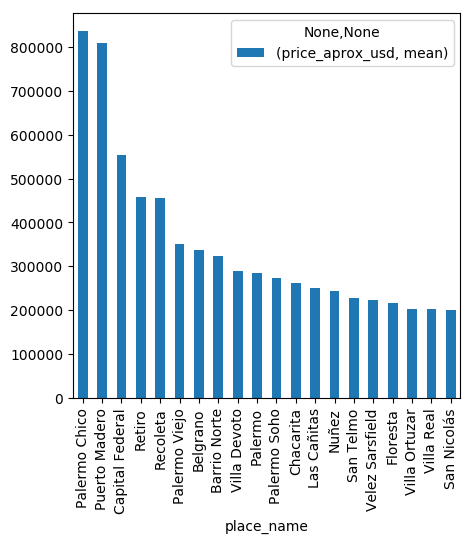

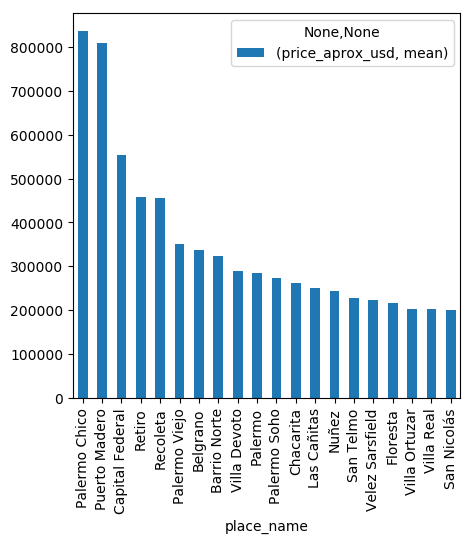

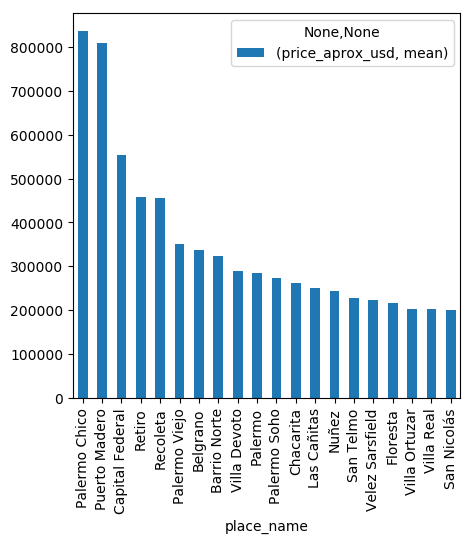

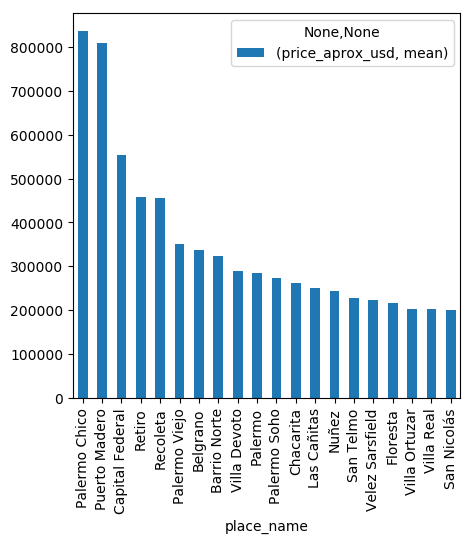

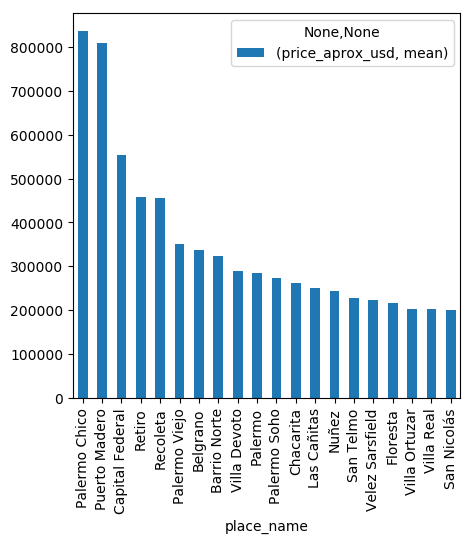

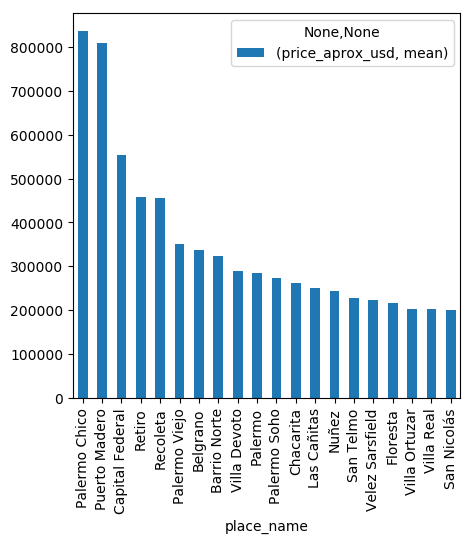

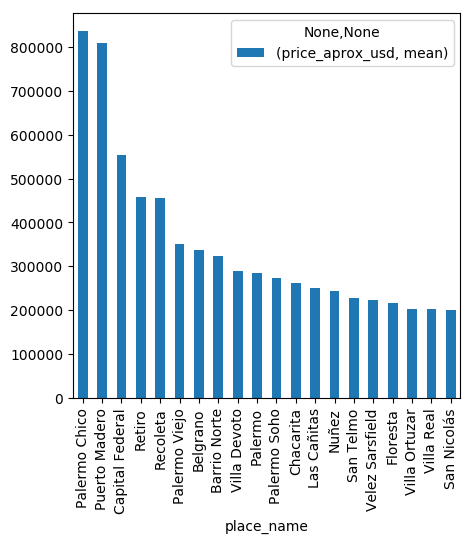

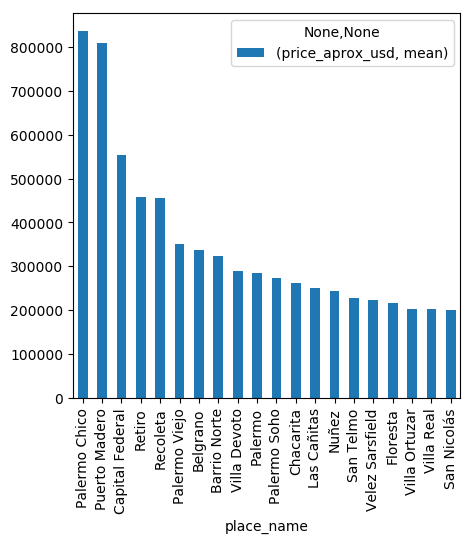

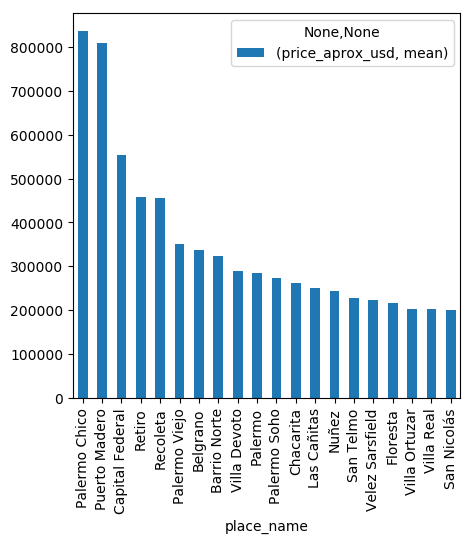

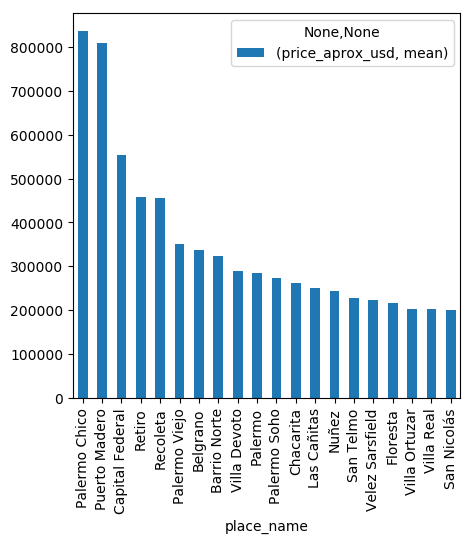

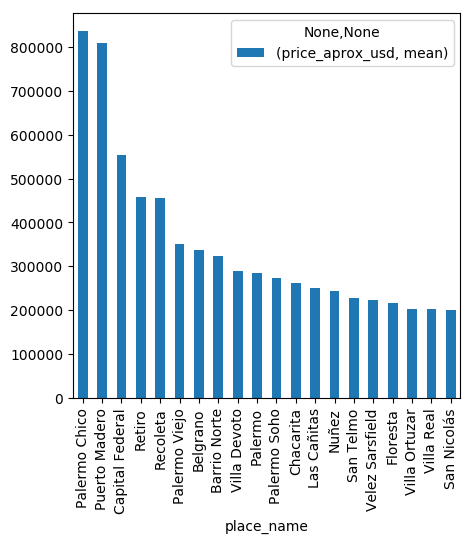

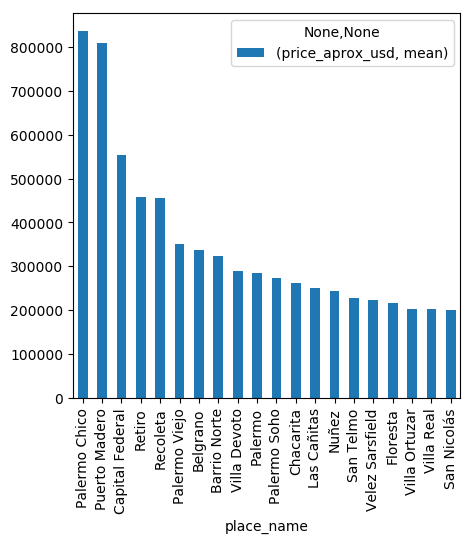

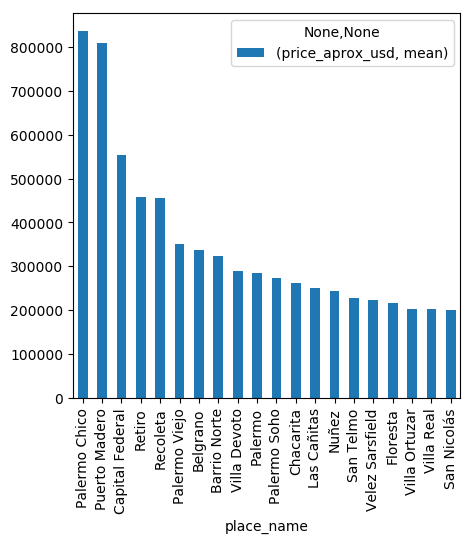

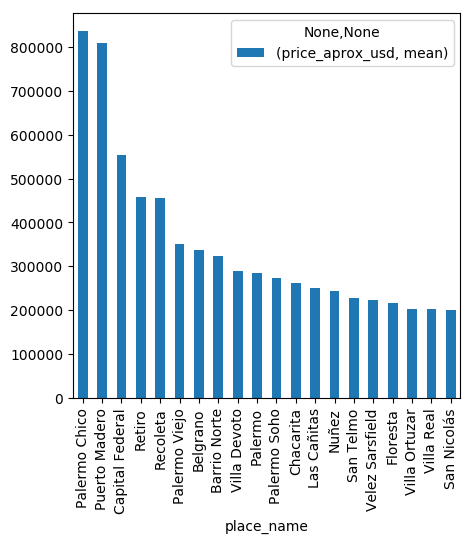

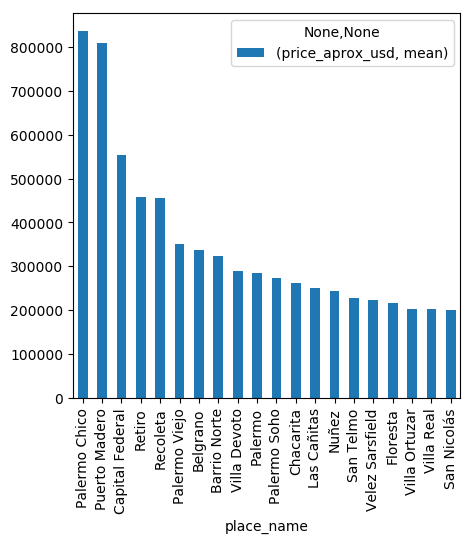

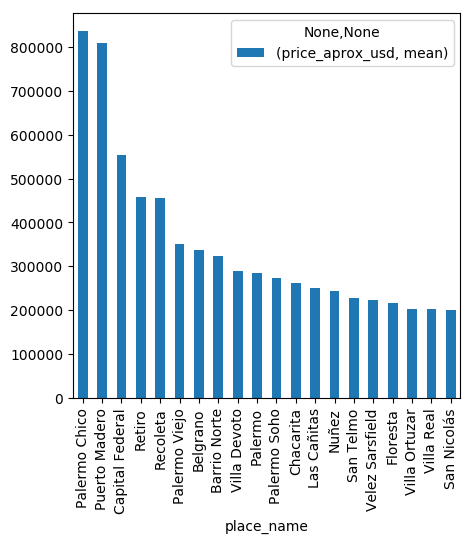

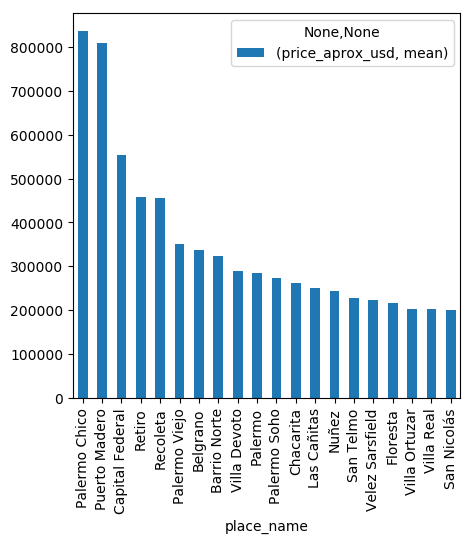

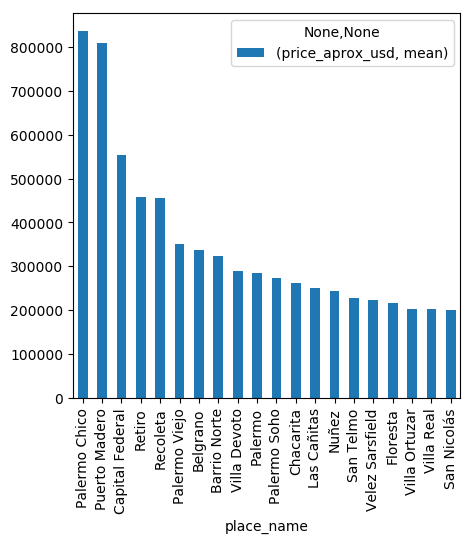

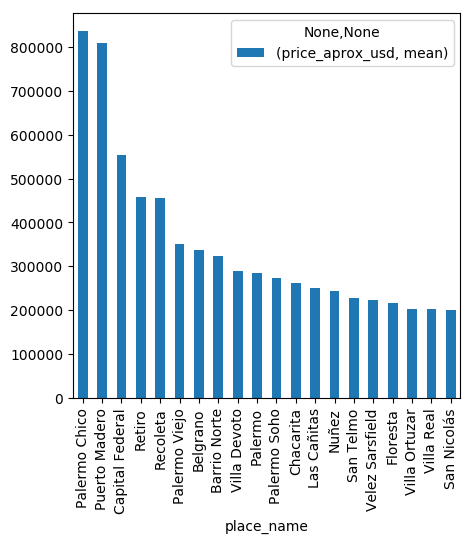

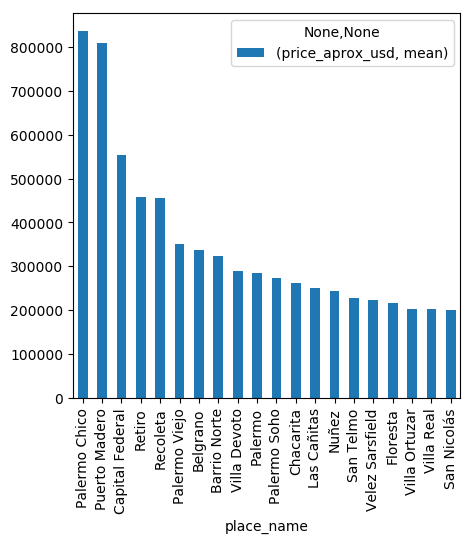

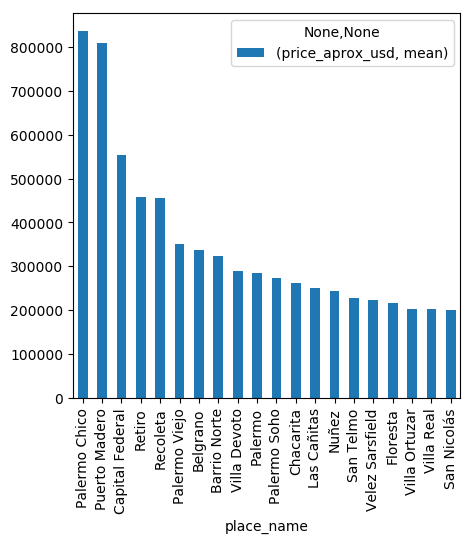

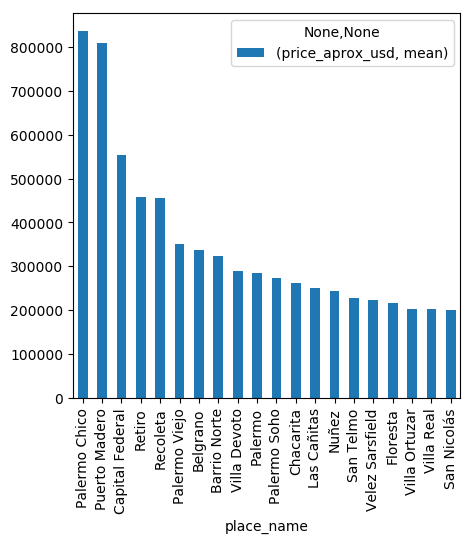

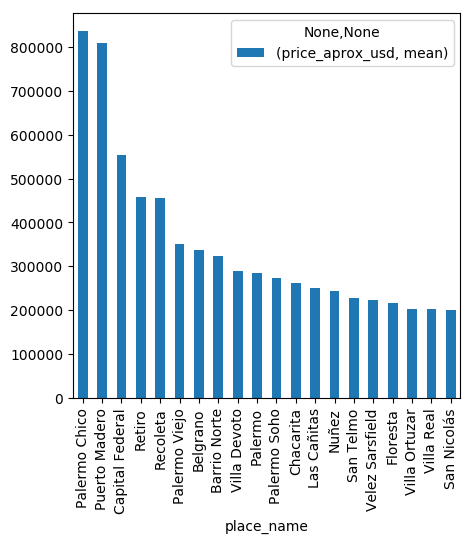

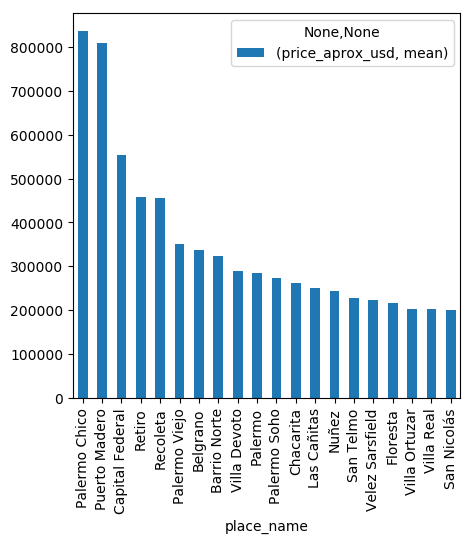

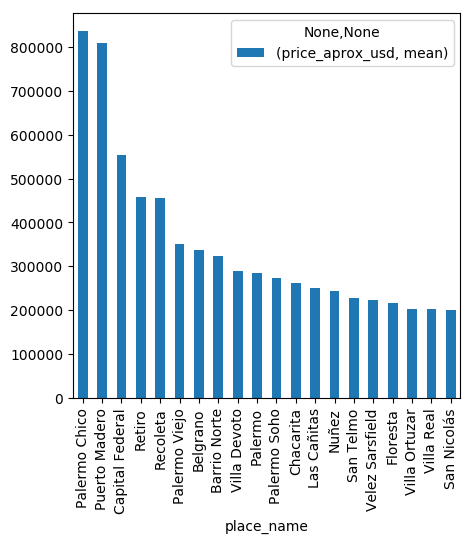

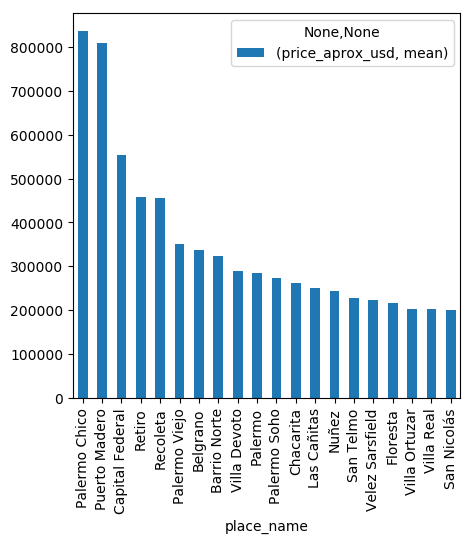

In [89]:
aux = []
for df in CFVec:
    dfAux = df.loc[:, ['price_aprox_usd', 'lat', 'lon', 'place_name']].groupby('place_name').agg([np.mean, np.size]).reset_index()
    dfAux = dfAux.sort_values(by=('price_aprox_usd', 'mean'), ascending=False).head(20)
    aux.insert(-1, dfAux)
    aux[-1].plot(x='place_name', y=('price_aprox_usd', 'mean') , kind='bar')